In [1]:
# --------------------------------------------------------------------------

# ----------------- error ratio analysis pls models and design conditions

# -------------------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


base_dir = "/home/u0106869/vfonsecad/kul_phd/programming/phd_valeria_fonseca_diaz_wp1/wp1_study002_sample_selection"

# --- data handling modules

import numpy as np
import pandas as pd
import scipy.io as sp_io
import scipy as sp

# --- visualization modules

import matplotlib.pyplot as plt
import matplotlib as mtply
import pandas as pd
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- my modules

methods_dir = base_dir + '/methodology/python'  
sys.path.insert(0, methods_dir + '/model_building')
sys.path.insert(0, methods_dir + '/read_data')
sys.path.insert(0, methods_dir + '/sample_selection')
from class_chemometrics_data import chemometrics_data
from class_mcw_pls import mcw_pls, mcw_pls_sklearn, min_rmsecv_lv_simpls, cv_lv_simpls
from class_sample_selection import sample_selection, covmap
import simpls_module




# ¡¡¡ --- !!! # ---> base working directory and available data cases


# ************************************ init --- user 
cases_dict = {"d0023": ["d0023_milkrobot_nirsensor2017", "d0023_data_prepared_06"],
              "d0024": ["d0024_pig_manure", "d0024_data_prepared_04"],             
             "d0025": ["d0025_apples_els", "d0025_data_prepared_04"]}
# ************************************ end --- user 


print("--------- imports loaded ----------")




# ¡¡¡ --- !!! # ---> data


# ************************************ init --- user 
caseID_key = "d0023"
expeID = "2020-09-29_0001"
# ************************************ end --- user 

case_dir = cases_dict[caseID_key][0]
dname = cases_dict[caseID_key][1]
data_dir = '/data/' + case_dir + '/data_prepared/'





# ************************************ init --- user
data_class = chemometrics_data(base_dir + data_dir + dname + '.mat', 
                               data_identifier = data_dir + dname,
                               include_val = False,
                               include_test = True,
                               include_unlabeled = False,
                               y_all_range = False,
                               y_range = np.array([2]),
                               obs_all_cal = True,
                              shuffle = False)
# ************************************ end --- user



print(data_class.ncal, data_class.K)
print(data_class.get_test()["xtest"].shape)
print("--------- data loaded for " + data_class.data_identifier + "----------")




--------- imports loaded ----------
316 256
(79, 256)
--------- data loaded for /data/d0023_milkrobot_nirsensor2017/data_prepared/d0023_data_prepared_06!*lactose*!----------


In [3]:
# --- initialize numba functions

total_lv = 25
output_pls = simpls_module.simpls_fit(xx=data_class.get_cal()["xcal"], yy=data_class.get_cal()["ycal"], ncp=total_lv)
ytest_pred = simpls_module.simpls_predict(data_class.get_test()["xtest"],  output_pls[0],output_pls[1],output_pls[2])
rmsep = simpls_module.rmse(data_class.get_test()["ytest"], ytest_pred, np.ones(ytest_pred.shape[0]))
r2p = simpls_module.r2(data_class.get_test()["ytest"], ytest_pred, np.ones(ytest_pred.shape[0]))
cv_output = simpls_module.simpls_univariate_cv(xx=data_class.get_cal()["xcal"], yy=data_class.get_cal()["ycal"], total_ncp=total_lv, number_splits=10)



print("done")

done


In [4]:
# --- get all results

df_design_pls = pd.read_pickle(base_dir + "/experiments/python/" + expeID + "/output/" + caseID_key + "_" + data_class.y_names[0] + "_numba_02_pls_performance.pkl")
method_name = np.unique(df_design_pls["method_name"])
sample_size = np.sort(pd.unique(df_design_pls["sample_size"]))
npc_range = np.sort(np.unique(df_design_pls["npc"]))[:-1]


df_design_pls.shape

(5360, 10)

In [5]:
# --- plot color mapping

color_var = np.arange(1,df_design_pls.iloc[0]["rmsecv"].shape[0]+1)
min_color_var = np.amin(color_var)-3
max_color_var = np.amax(color_var)+2

c_m = mtply.cm.hot
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)

ylims_plots = {"rmsep":[0.04, 0.16], "r2p":[0.1,1.1]} # lactose


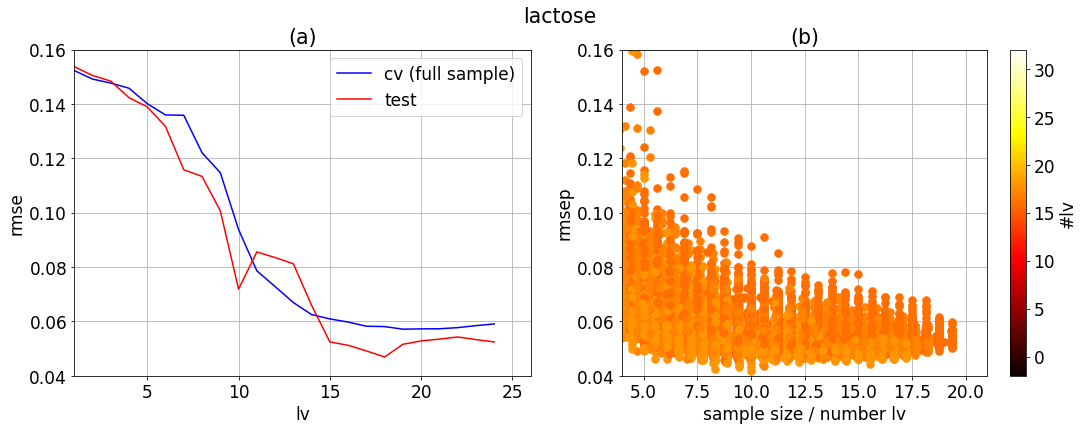

In [13]:
# --- visualization rmse



# ************************************
optimal_lv_range = np.arange(16,19)
variable_name="rmsep"
# ************************************

plt.rcParams.update({'font.size': 17})
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))


axs[0].plot(cv_output[0], c="blue")
axs[0].plot(rmsep[:,0], c = "red")
axs[0].set_title("(a)")
axs[0].set_xlim([1,total_lv+1])
axs[0].set_ylim(ylims_plots[variable_name])
axs[0].set_xlabel("lv")
axs[0].set_ylabel("rmse")
axs[0].legend(["cv (full sample)", "test"])
axs[0].grid()

for row_ii in range(df_design_pls.shape[0]):

    df_plot_row = df_design_pls.iloc[row_ii]
    current_sample_size = df_plot_row["selected_samples"].sum()
    plot_values = df_plot_row[variable_name][1]

    for pp in range(optimal_lv_range.shape[0]):
        
        color_tuple = s_m.to_rgba(optimal_lv_range[pp])
        axs[1].plot(current_sample_size/optimal_lv_range[pp] ,plot_values[optimal_lv_range[pp]-1],'.', c=color_tuple, markerSize = 15)
        
        
axs[1].grid()
axs[1].set_xlabel("sample size / number lv")
axs[1].set_ylabel(variable_name)
axs[1].set_xlim([4,21])
axs[1].set_ylim(ylims_plots[variable_name])
axs[1].set_title("(b)")

cm = fig.colorbar(s_m)
cm.set_label("#lv")
plt.suptitle(data_class.y_names[0])
plt.savefig(base_dir + "/manuscript/figures/d0023_03_general_framework.png",bbox_inches="tight")
plt.show()